In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [20, 10]

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
tf.keras.backend.clear_session()

In [2]:
dataset = pd.read_csv('measurements.csv', sep=';', decimal=',')
dataset = dataset.dropna()
dataset.drop(dataset.columns[[0, 1, 2]], axis = 1, inplace = True) 

max_tube_diameter = np.min(dataset[['AP cricoïde', 'AP fin de trachée', 'T fin de trachée']], axis=1)
dataset= dataset.iloc[:, :3]
dataset['max_tube_diameter'] = max_tube_diameter

cuffless_OD = np.array([2.9, 3.6, 4.2, 4.9, 5.5, 6.2, 6.8, 7.5, 8.2, 8.8, 9.6])
cuffed_OD = np.array([4.2, 5.5, 6.8, 7.5, 8.2, 8.8, 9.6, 10.2, 10.9, 11.5, 12.1, 12.8, 13.5])

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age en mois,154.0,85.993506,51.391169,1.00,36.0000,85.500,131.7500,176.0
sexe (0=M/1=F),154.0,0.350649,0.478730,0.00,0.0000,0.000,1.0000,1.0
poids,154.0,27.760390,15.704075,4.00,15.0000,25.000,36.5500,90.0
max_tube_diameter,154.0,7.432532,1.997008,2.81,6.1925,7.295,8.7675,12.6


In [4]:
train_features = train_dataset.copy()
train_target = train_features.pop('max_tube_diameter')

test_features = test_dataset.copy()
test_target = test_features.pop('max_tube_diameter')

In [5]:
od = np.array([cuffless_OD[np.abs(cuffless_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter']])
test_dataset['OD cuffless ref'] = cuffless_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter'] - od),
                                                [np.where(cuffless_OD == c)[0].item() for c in od])], 0)]


od = np.array([cuffed_OD[np.abs(cuffed_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter']])
test_dataset['OD cuffed ref'] = cuffed_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter'] - od),
                                                [np.where(cuffed_OD == c)[0].item() for c in od])], 0)]

# Linear Regression

In [6]:
reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=42)
reg.fit(np.array(train_features['age en mois']).reshape(-1, 1), train_target)

ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             random_state=42)

In [7]:
test_dataset['max_tube_diameter LR'] = reg.predict(np.array(test_features['age en mois']).reshape(-1, 1))

od = np.array([cuffless_OD[np.abs(cuffless_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter LR']])
test_dataset['OD cuffless LR'] = cuffless_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter LR'] - od),
                                                [np.where(cuffless_OD == c)[0].item() for c in od])], 0)]


od = np.array([cuffed_OD[np.abs(cuffed_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter LR']])
test_dataset['OD cuffed LR'] = cuffed_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter LR'] - od),
                                                [np.where(cuffed_OD == c)[0].item() for c in od])], 0)]

# Random Forest

In [8]:
forest = RandomForestRegressor(random_state=42)

hyper_parameters = dict(n_estimators = [100, 300, 500, 800, 1200],
                        max_depth = [5, 8, 15, 25, 30, 50, 100, 150],
                        min_samples_split = [2, 5, 10, 15, 30, 50, 100],
                        min_samples_leaf = [1, 2, 5, 10, 15])

grid_search = GridSearchCV(forest, hyper_parameters, cv = 5, verbose = 1, n_jobs = 20)

best_rf = grid_search.fit(train_features, train_target)

Fitting 5 folds for each of 1400 candidates, totalling 7000 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:   30.7s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  1.2min
[Parallel(n_jobs=20)]: Done 760 tasks      | elapsed:  2.1min
[Parallel(n_jobs=20)]: Done 1210 tasks      | elapsed:  3.2min
[Parallel(n_jobs=20)]: Done 1760 tasks      | elapsed:  4.7min
[Parallel(n_jobs=20)]: Done 2410 tasks      | elapsed:  6.4min
[Parallel(n_jobs=20)]: Done 3160 tasks      | elapsed:  8.3min
[Parallel(n_jobs=20)]: Done 4010 tasks      | elapsed: 10.5min
[Parallel(n_jobs=20)]: Done 4960 tasks      | elapsed: 13.0min
[Parallel(n_jobs=20)]: Done 6010 tasks      | elapsed: 15.7min
[Parallel(n_jobs=20)]: Done 7000 out of 7000 | elapsed: 18.3min finished


In [9]:
test_dataset['max_tube_diameter RF'] = best_rf.predict(test_features)

od = np.array([cuffless_OD[np.abs(cuffless_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter RF']])
test_dataset['OD cuffless RF'] = cuffless_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter RF'] - od),
                                                [np.where(cuffless_OD == c)[0].item() for c in od])], 0)]


od = np.array([cuffed_OD[np.abs(cuffed_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter RF']])
test_dataset['OD cuffed RF'] = cuffed_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter RF'] - od),
                                                [np.where(cuffed_OD == c)[0].item() for c in od])], 0)]

# Neural Network

In [10]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])


model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(),
            tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(x=train_features, y=train_target,
                    validation_data=(test_features, test_target),
                    epochs=300)

Epoch 1/300
5/5 [==============================] - 0s 28ms/step - loss: 55.6881 - root_mean_squared_error: 7.4624 - mean_absolute_error: 7.1986 - val_loss: 58.4067 - val_root_mean_squared_error: 7.6424 - val_mean_absolute_error: 7.4165
Epoch 2/300
5/5 [==============================] - 0s 4ms/step - loss: 54.4061 - root_mean_squared_error: 7.3760 - mean_absolute_error: 7.1090 - val_loss: 57.1184 - val_root_mean_squared_error: 7.5577 - val_mean_absolute_error: 7.3296
Epoch 3/300
5/5 [==============================] - 0s 4ms/step - loss: 53.1501 - root_mean_squared_error: 7.2904 - mean_absolute_error: 7.0195 - val_loss: 55.8576 - val_root_mean_squared_error: 7.4738 - val_mean_absolute_error: 7.2434
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 51.9806 - root_mean_squared_error: 7.2098 - mean_absolute_error: 6.9308 - val_loss: 54.6003 - val_root_mean_squared_error: 7.3892 - val_mean_absolute_error: 7.1570
Epoch 5/300
5/5 [==============================] - 0s 6ms/s

Epoch 36/300
5/5 [==============================] - 0s 6ms/step - loss: 15.0972 - root_mean_squared_error: 3.8855 - mean_absolute_error: 3.4976 - val_loss: 15.3459 - val_root_mean_squared_error: 3.9174 - val_mean_absolute_error: 3.6016
Epoch 37/300
5/5 [==============================] - 0s 6ms/step - loss: 14.2181 - root_mean_squared_error: 3.7707 - mean_absolute_error: 3.3843 - val_loss: 14.4169 - val_root_mean_squared_error: 3.7970 - val_mean_absolute_error: 3.4763
Epoch 38/300
5/5 [==============================] - 0s 5ms/step - loss: 13.4012 - root_mean_squared_error: 3.6608 - mean_absolute_error: 3.2756 - val_loss: 13.5440 - val_root_mean_squared_error: 3.6802 - val_mean_absolute_error: 3.3625
Epoch 39/300
5/5 [==============================] - 0s 5ms/step - loss: 12.6437 - root_mean_squared_error: 3.5558 - mean_absolute_error: 3.1701 - val_loss: 12.7135 - val_root_mean_squared_error: 3.5656 - val_mean_absolute_error: 3.2513
Epoch 40/300
5/5 [==============================] - 0s 4

Epoch 71/300
5/5 [==============================] - 0s 4ms/step - loss: 3.4343 - root_mean_squared_error: 1.8532 - mean_absolute_error: 1.5314 - val_loss: 3.2051 - val_root_mean_squared_error: 1.7903 - val_mean_absolute_error: 1.5070
Epoch 72/300
5/5 [==============================] - 0s 4ms/step - loss: 3.3573 - root_mean_squared_error: 1.8323 - mean_absolute_error: 1.5119 - val_loss: 3.1285 - val_root_mean_squared_error: 1.7687 - val_mean_absolute_error: 1.4901
Epoch 73/300
5/5 [==============================] - 0s 4ms/step - loss: 3.2777 - root_mean_squared_error: 1.8104 - mean_absolute_error: 1.4936 - val_loss: 3.0557 - val_root_mean_squared_error: 1.7480 - val_mean_absolute_error: 1.4742
Epoch 74/300
5/5 [==============================] - 0s 4ms/step - loss: 3.2017 - root_mean_squared_error: 1.7893 - mean_absolute_error: 1.4748 - val_loss: 2.9878 - val_root_mean_squared_error: 1.7285 - val_mean_absolute_error: 1.4588
Epoch 75/300
5/5 [==============================] - 0s 4ms/step 

Epoch 106/300
5/5 [==============================] - 0s 4ms/step - loss: 1.9600 - root_mean_squared_error: 1.4000 - mean_absolute_error: 1.1371 - val_loss: 1.9905 - val_root_mean_squared_error: 1.4109 - val_mean_absolute_error: 1.1656
Epoch 107/300
5/5 [==============================] - 0s 4ms/step - loss: 1.9424 - root_mean_squared_error: 1.3937 - mean_absolute_error: 1.1320 - val_loss: 1.9832 - val_root_mean_squared_error: 1.4083 - val_mean_absolute_error: 1.1617
Epoch 108/300
5/5 [==============================] - 0s 4ms/step - loss: 1.9221 - root_mean_squared_error: 1.3864 - mean_absolute_error: 1.1256 - val_loss: 1.9742 - val_root_mean_squared_error: 1.4051 - val_mean_absolute_error: 1.1570
Epoch 109/300
5/5 [==============================] - 0s 4ms/step - loss: 1.9068 - root_mean_squared_error: 1.3809 - mean_absolute_error: 1.1205 - val_loss: 1.9634 - val_root_mean_squared_error: 1.4012 - val_mean_absolute_error: 1.1523
Epoch 110/300
5/5 [==============================] - 0s 4ms/

Epoch 141/300
5/5 [==============================] - 0s 4ms/step - loss: 1.5471 - root_mean_squared_error: 1.2438 - mean_absolute_error: 1.0155 - val_loss: 1.7928 - val_root_mean_squared_error: 1.3389 - val_mean_absolute_error: 1.0815
Epoch 142/300
5/5 [==============================] - 0s 4ms/step - loss: 1.5400 - root_mean_squared_error: 1.2410 - mean_absolute_error: 1.0134 - val_loss: 1.7943 - val_root_mean_squared_error: 1.3395 - val_mean_absolute_error: 1.0814
Epoch 143/300
5/5 [==============================] - 0s 4ms/step - loss: 1.5344 - root_mean_squared_error: 1.2387 - mean_absolute_error: 1.0122 - val_loss: 1.7955 - val_root_mean_squared_error: 1.3400 - val_mean_absolute_error: 1.0817
Epoch 144/300
5/5 [==============================] - 0s 4ms/step - loss: 1.5275 - root_mean_squared_error: 1.2359 - mean_absolute_error: 1.0100 - val_loss: 1.7913 - val_root_mean_squared_error: 1.3384 - val_mean_absolute_error: 1.0793
Epoch 145/300
5/5 [==============================] - 0s 4ms/

Epoch 176/300
5/5 [==============================] - 0s 4ms/step - loss: 1.3804 - root_mean_squared_error: 1.1749 - mean_absolute_error: 0.9561 - val_loss: 1.7976 - val_root_mean_squared_error: 1.3408 - val_mean_absolute_error: 1.0578
Epoch 177/300
5/5 [==============================] - 0s 4ms/step - loss: 1.3777 - root_mean_squared_error: 1.1738 - mean_absolute_error: 0.9548 - val_loss: 1.8002 - val_root_mean_squared_error: 1.3417 - val_mean_absolute_error: 1.0583
Epoch 178/300
5/5 [==============================] - 0s 4ms/step - loss: 1.3766 - root_mean_squared_error: 1.1733 - mean_absolute_error: 0.9546 - val_loss: 1.8030 - val_root_mean_squared_error: 1.3428 - val_mean_absolute_error: 1.0595
Epoch 179/300
5/5 [==============================] - 0s 4ms/step - loss: 1.3705 - root_mean_squared_error: 1.1707 - mean_absolute_error: 0.9523 - val_loss: 1.8010 - val_root_mean_squared_error: 1.3420 - val_mean_absolute_error: 1.0571
Epoch 180/300
5/5 [==============================] - 0s 4ms/

Epoch 211/300
5/5 [==============================] - 0s 4ms/step - loss: 1.2858 - root_mean_squared_error: 1.1339 - mean_absolute_error: 0.9175 - val_loss: 1.8378 - val_root_mean_squared_error: 1.3557 - val_mean_absolute_error: 1.0575
Epoch 212/300
5/5 [==============================] - 0s 4ms/step - loss: 1.2843 - root_mean_squared_error: 1.1332 - mean_absolute_error: 0.9170 - val_loss: 1.8331 - val_root_mean_squared_error: 1.3539 - val_mean_absolute_error: 1.0545
Epoch 213/300
5/5 [==============================] - 0s 5ms/step - loss: 1.2832 - root_mean_squared_error: 1.1328 - mean_absolute_error: 0.9165 - val_loss: 1.8362 - val_root_mean_squared_error: 1.3550 - val_mean_absolute_error: 1.0556
Epoch 214/300
5/5 [==============================] - 0s 4ms/step - loss: 1.2789 - root_mean_squared_error: 1.1309 - mean_absolute_error: 0.9149 - val_loss: 1.8358 - val_root_mean_squared_error: 1.3549 - val_mean_absolute_error: 1.0554
Epoch 215/300
5/5 [==============================] - 0s 4ms/

Epoch 246/300
5/5 [==============================] - 0s 4ms/step - loss: 1.2303 - root_mean_squared_error: 1.1092 - mean_absolute_error: 0.8929 - val_loss: 1.8648 - val_root_mean_squared_error: 1.3656 - val_mean_absolute_error: 1.0646
Epoch 247/300
5/5 [==============================] - 0s 4ms/step - loss: 1.2295 - root_mean_squared_error: 1.1088 - mean_absolute_error: 0.8928 - val_loss: 1.8721 - val_root_mean_squared_error: 1.3683 - val_mean_absolute_error: 1.0679
Epoch 248/300
5/5 [==============================] - 0s 4ms/step - loss: 1.2275 - root_mean_squared_error: 1.1079 - mean_absolute_error: 0.8914 - val_loss: 1.8731 - val_root_mean_squared_error: 1.3686 - val_mean_absolute_error: 1.0680
Epoch 249/300
5/5 [==============================] - 0s 4ms/step - loss: 1.2262 - root_mean_squared_error: 1.1073 - mean_absolute_error: 0.8907 - val_loss: 1.8722 - val_root_mean_squared_error: 1.3683 - val_mean_absolute_error: 1.0669
Epoch 250/300
5/5 [==============================] - 0s 4ms/

Epoch 281/300
5/5 [==============================] - 0s 4ms/step - loss: 1.1967 - root_mean_squared_error: 1.0940 - mean_absolute_error: 0.8799 - val_loss: 1.9007 - val_root_mean_squared_error: 1.3787 - val_mean_absolute_error: 1.0743
Epoch 282/300
5/5 [==============================] - 0s 4ms/step - loss: 1.1960 - root_mean_squared_error: 1.0936 - mean_absolute_error: 0.8796 - val_loss: 1.9014 - val_root_mean_squared_error: 1.3789 - val_mean_absolute_error: 1.0748
Epoch 283/300
5/5 [==============================] - 0s 4ms/step - loss: 1.1963 - root_mean_squared_error: 1.0938 - mean_absolute_error: 0.8793 - val_loss: 1.9122 - val_root_mean_squared_error: 1.3828 - val_mean_absolute_error: 1.0800
Epoch 284/300
5/5 [==============================] - 0s 4ms/step - loss: 1.1934 - root_mean_squared_error: 1.0924 - mean_absolute_error: 0.8781 - val_loss: 1.9099 - val_root_mean_squared_error: 1.3820 - val_mean_absolute_error: 1.0784
Epoch 285/300
5/5 [==============================] - 0s 4ms/

In [11]:
test_dataset['max_tube_diameter NN'] = [model(np.array([row[1][:3]])).numpy().item() for row in test_dataset.iterrows()]

od = np.array([cuffless_OD[np.abs(cuffless_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter NN']])
test_dataset['OD cuffless NN'] = cuffless_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter NN'] - od),
                                                [np.where(cuffless_OD == c)[0].item() for c in od])], 0)]


od = np.array([cuffed_OD[np.abs(cuffed_OD - mtd).argmin()] for mtd in test_dataset['max_tube_diameter NN']])
test_dataset['OD cuffed NN'] = cuffed_OD[np.maximum([j if i>0 else j-1 
                                for i, j in zip(np.sign(test_dataset['max_tube_diameter NN'] - od),
                                                [np.where(cuffed_OD == c)[0].item() for c in od])], 0)]

# Results

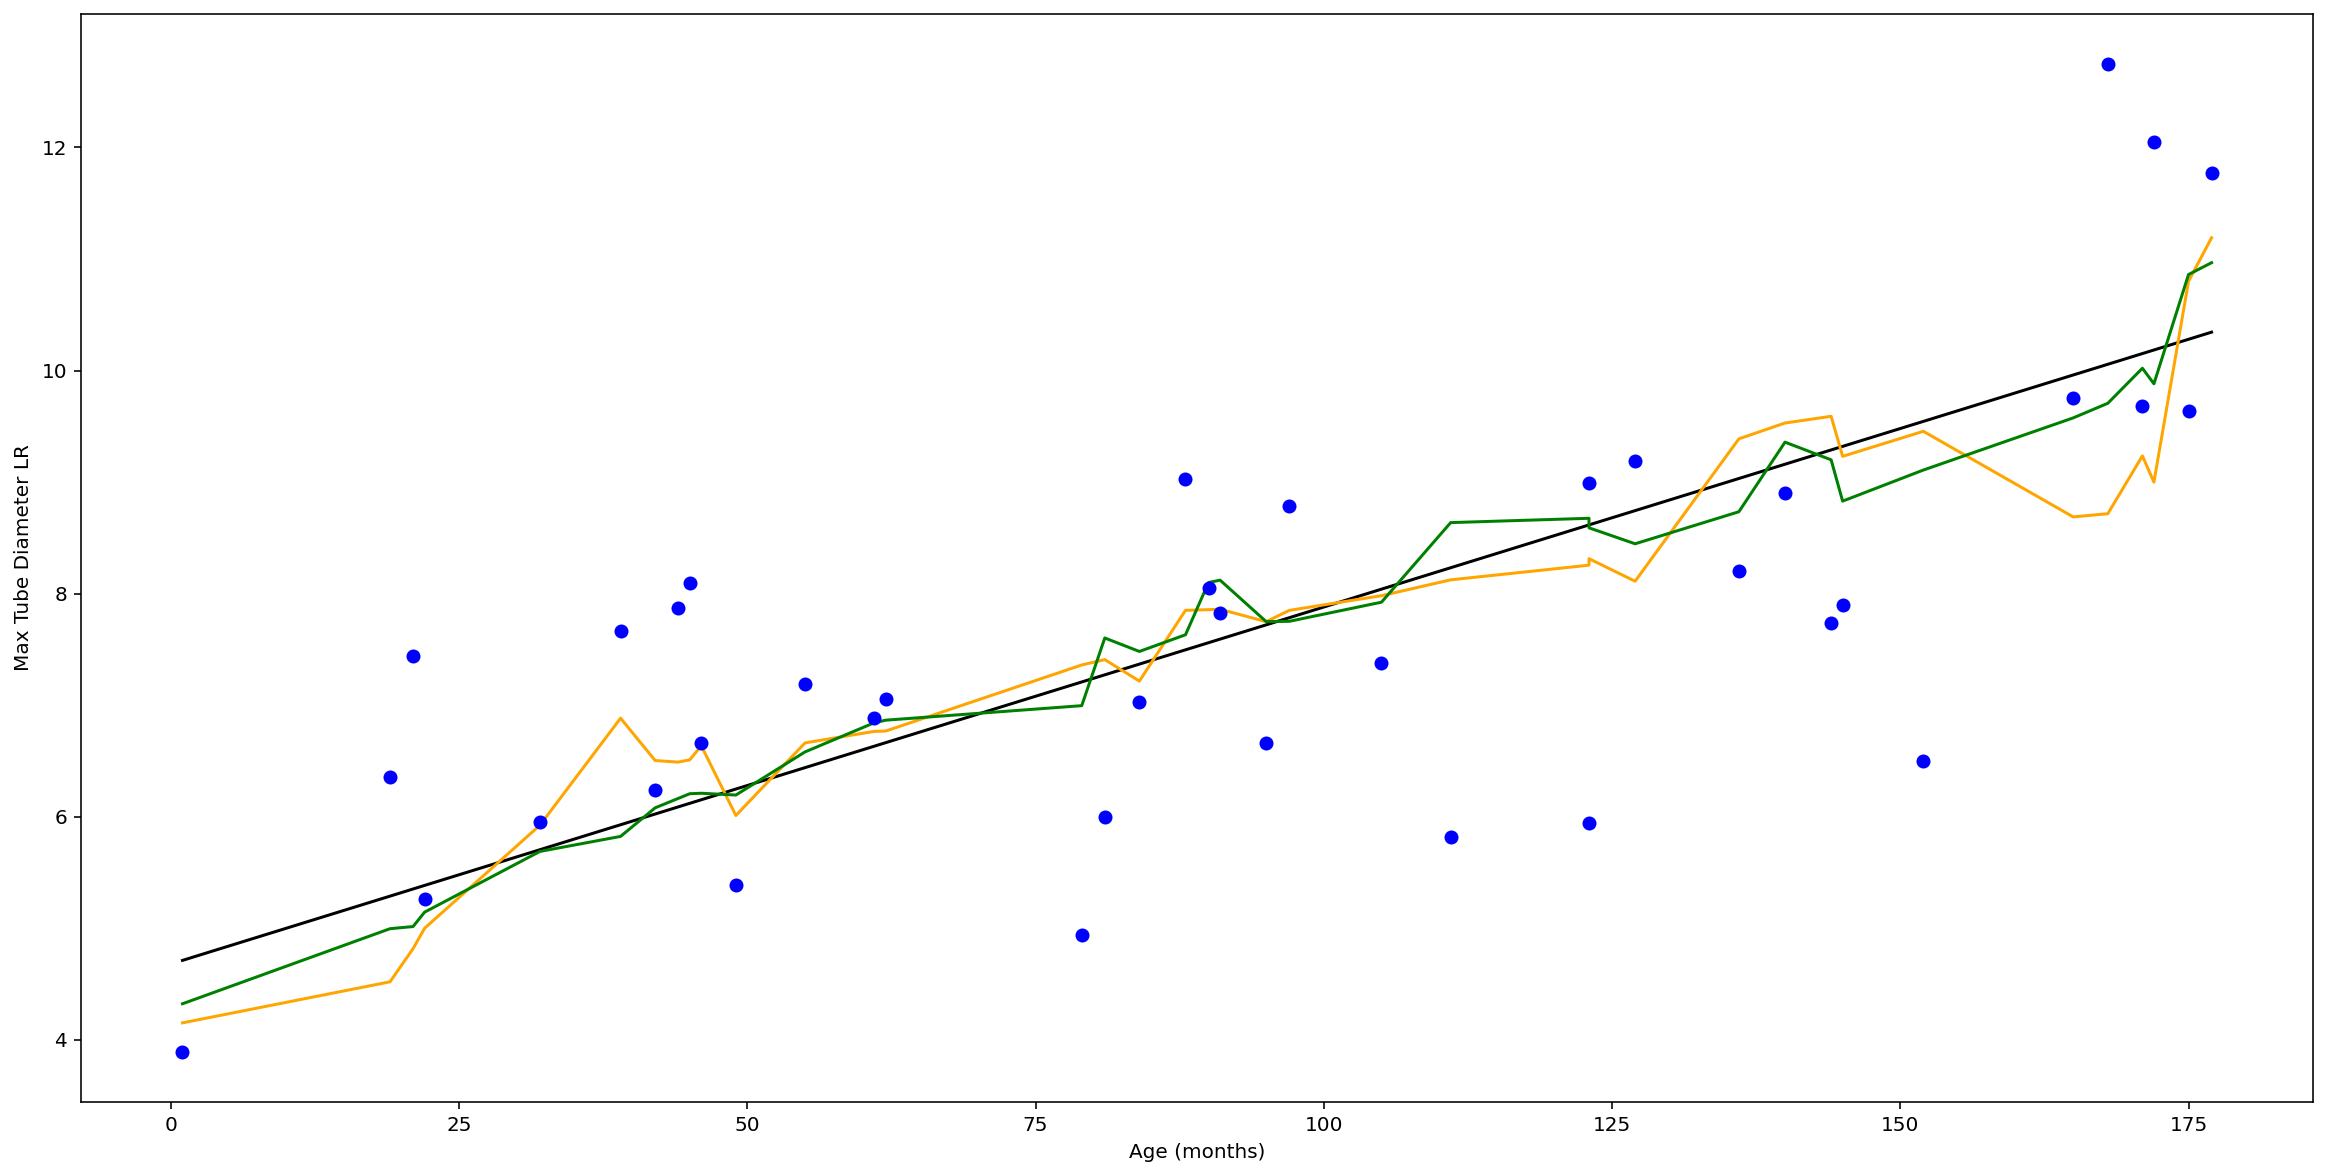

In [22]:
plt.plot(test_dataset['age en mois'], test_dataset['max_tube_diameter LR'], 'black');
plt.plot(test_dataset['age en mois'], test_dataset['max_tube_diameter RF'], 'orange');
plt.plot(test_dataset['age en mois'], test_dataset['max_tube_diameter NN'], 'g');
plt.plot(test_dataset['age en mois'], test_dataset['max_tube_diameter'], 'ob');
plt.xlabel("Age (months)");
plt.ylabel("Max Tube Diameter LR");

In [23]:
print('--- Cuffless predictions ---')
print()
print('LR Adapted diameter: {:.2%}'.format(sum(test_dataset['OD cuffless LR'] <= test_dataset['OD cuffless ref']) / len(test_dataset)))
print('RF Adapted diameter: {:.2%}'.format(sum(test_dataset['OD cuffless RF'] <= test_dataset['OD cuffless ref']) / len(test_dataset)))
print('NN Adapted diameter: {:.2%}'.format(sum(test_dataset['OD cuffless NN'] <= test_dataset['OD cuffless ref']) / len(test_dataset)))
print()
print('LR Exact diameter: {:.2%}'.format(sum(test_dataset['OD cuffless LR'] == test_dataset['OD cuffless ref']) / len(test_dataset)))
print('RF Exact diameter: {:.2%}'.format(sum(test_dataset['OD cuffless RF'] == test_dataset['OD cuffless ref']) / len(test_dataset)))
print('NN Exact diameter: {:.2%}'.format(sum(test_dataset['OD cuffless NN'] == test_dataset['OD cuffless ref']) / len(test_dataset)))
print()
print('--- Cuffed prediction ---')
print()
print('LR Adapted diameter: {:.2%}'.format(sum(test_dataset['OD cuffed LR'] <= test_dataset['OD cuffed ref']) / len(test_dataset)))
print('RF Adapted diameter: {:.2%}'.format(sum(test_dataset['OD cuffed RF'] <= test_dataset['OD cuffed ref']) / len(test_dataset)))
print('NN Adapted diameter: {:.2%}'.format(sum(test_dataset['OD cuffed NN'] <= test_dataset['OD cuffed ref']) / len(test_dataset)))
print()
print('LR Exact diameter: {:.2%}'.format(sum(test_dataset['OD cuffed LR'] == test_dataset['OD cuffed ref']) / len(test_dataset)))
print('RF Exact diameter: {:.2%}'.format(sum(test_dataset['OD cuffed RF'] == test_dataset['OD cuffed ref']) / len(test_dataset)))
print('NN Exact diameter: {:.2%}'.format(sum(test_dataset['OD cuffed NN'] == test_dataset['OD cuffed ref']) / len(test_dataset)))

--- Cuffless predictions ---

LR Adapted diameter: 68.42%
RF Adapted diameter: 71.05%
NN Adapted diameter: 68.42%

LR Exact diameter: 31.58%
RF Exact diameter: 28.95%
NN Exact diameter: 36.84%

--- Cuffed prediction ---

LR Adapted diameter: 68.42%
RF Adapted diameter: 68.42%
NN Adapted diameter: 68.42%

LR Exact diameter: 28.95%
RF Exact diameter: 23.68%
NN Exact diameter: 31.58%


MAE_val: 1.0487700700759888
RMSE_val: 1.3325600624084473


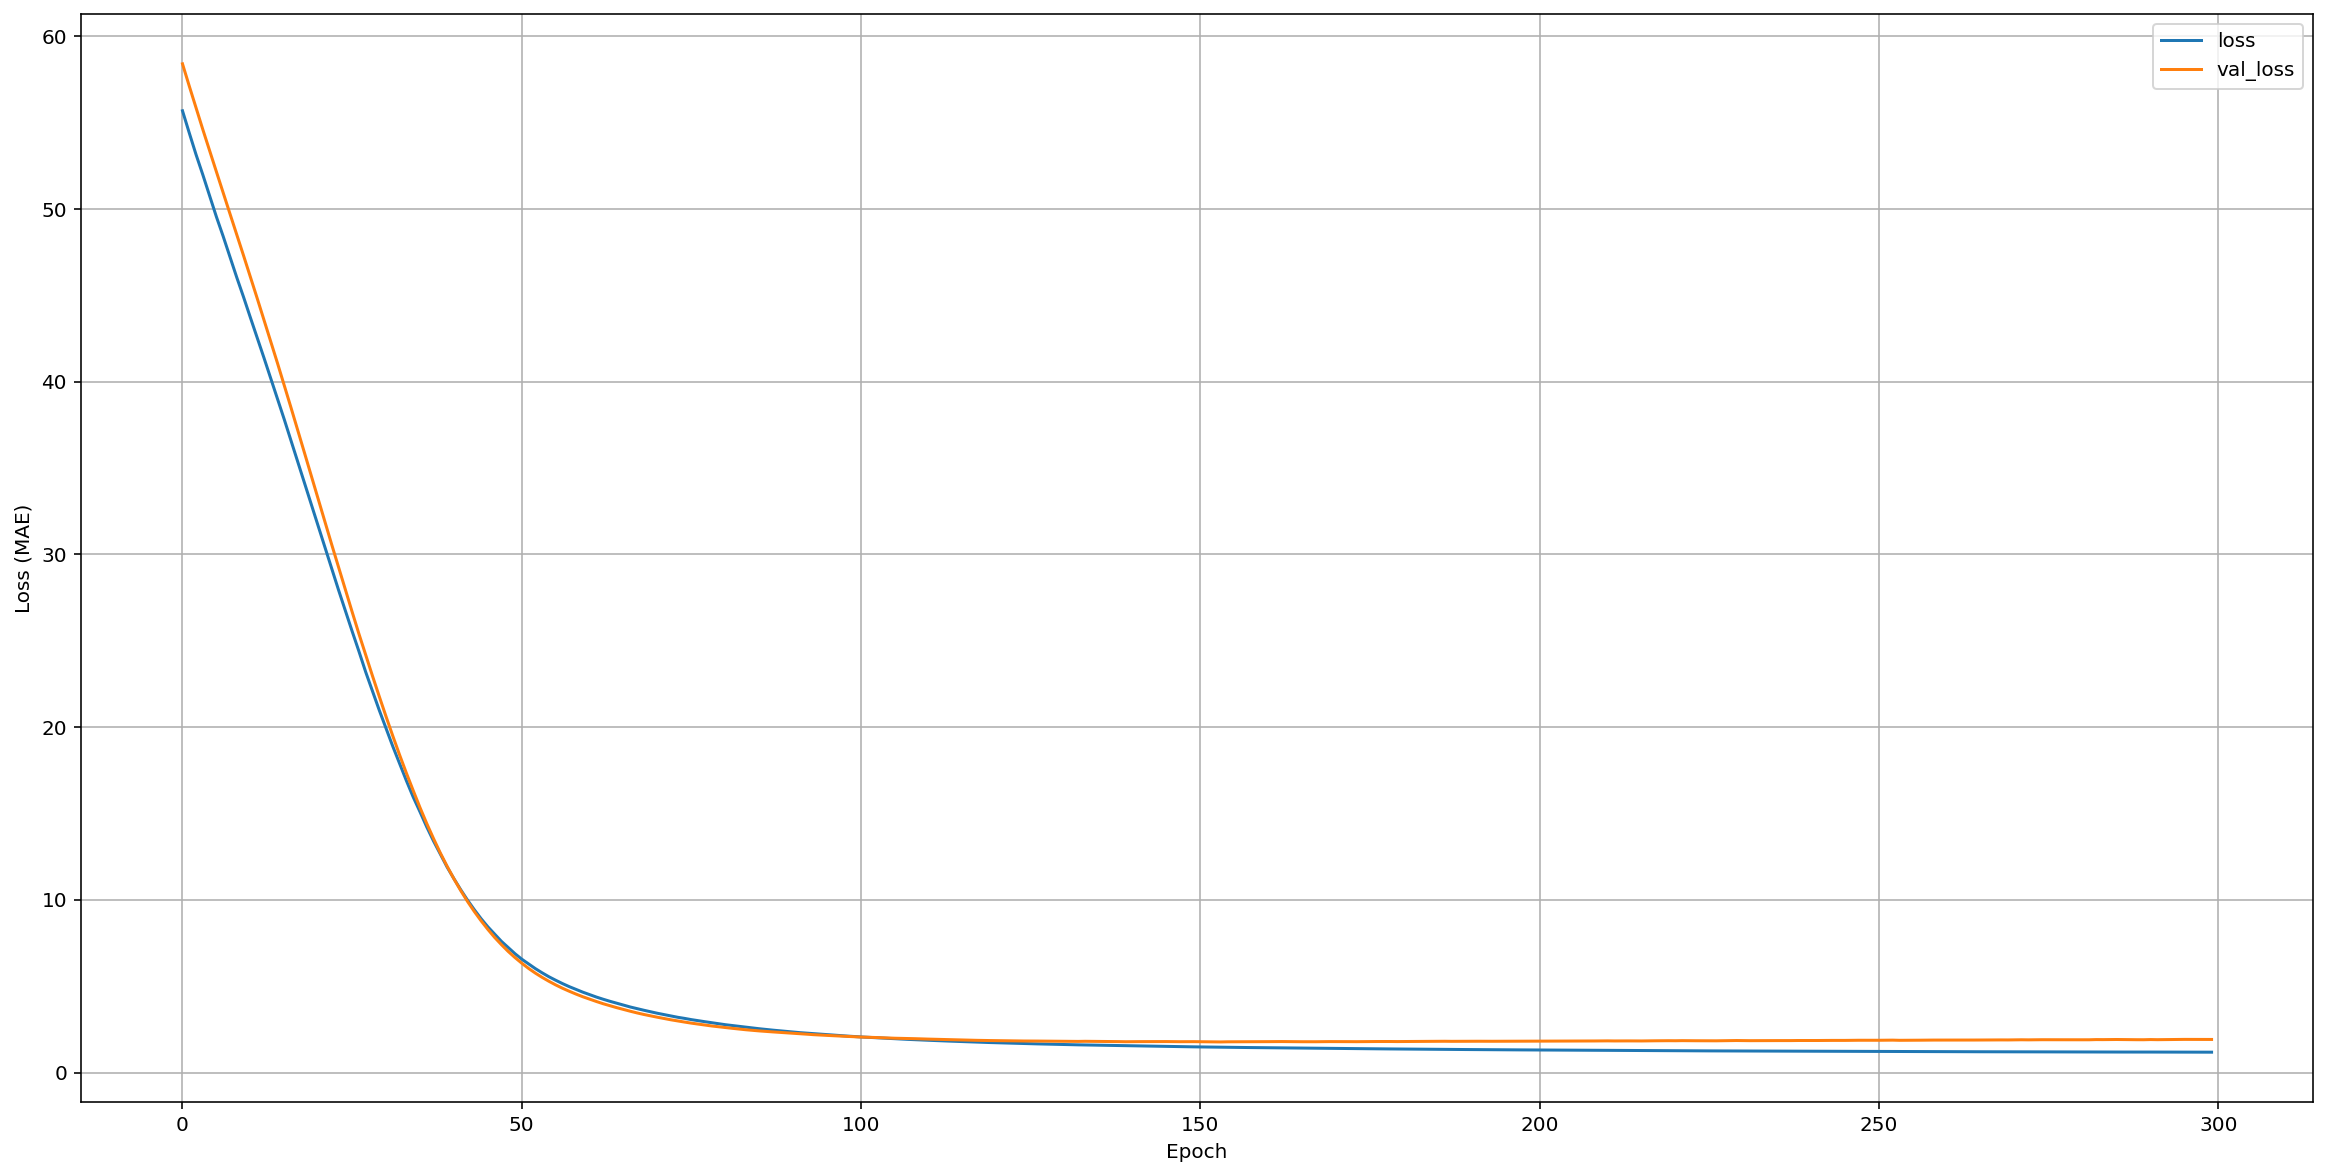

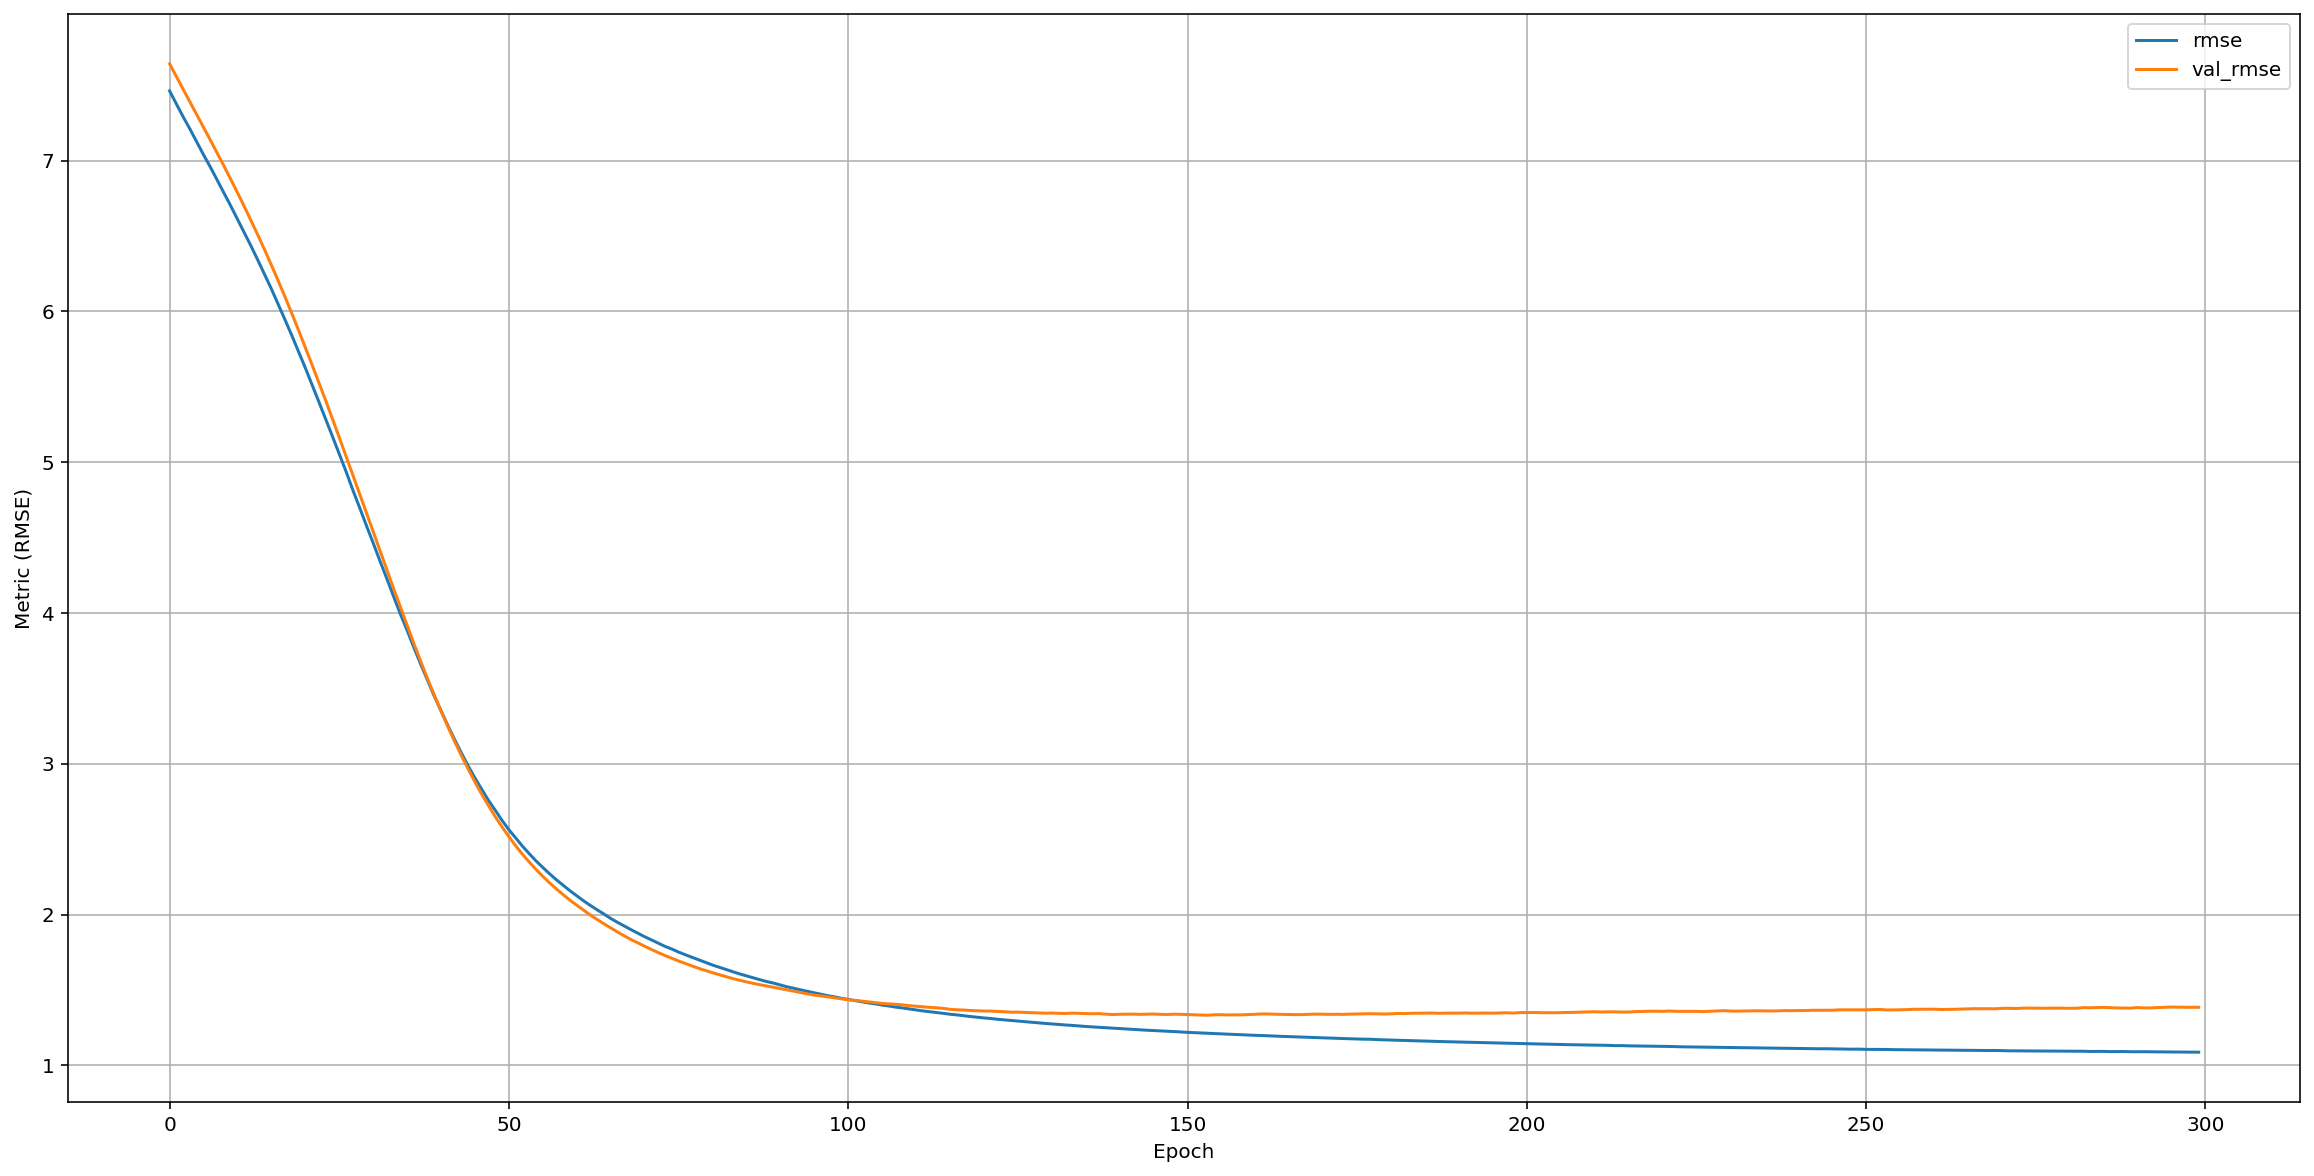

In [14]:
def plot_loss(history, name):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (' + name + ')')
    plt.legend()
    plt.grid(True)
    
def plot_rmse(history, name):
    plt.plot(history.history['root_mean_squared_error'], label='rmse')
    plt.plot(history.history['val_root_mean_squared_error'], label='val_rmse')
    plt.xlabel('Epoch')
    plt.ylabel('Metric (' + name + ')')
    plt.legend()
    plt.grid(True)
    
print('MAE_val: {}'.format(min(history.history['val_mean_absolute_error'])))
print('RMSE_val: {}'.format(min(history.history['val_root_mean_squared_error'])))

plot_loss(history, 'MAE');
plt.show();
plot_rmse(history, 'RMSE');

In [15]:
test_dataset.head()

,age en mois,sexe (0=M/1=F),poids,max_tube_diameter,OD cuffless ref,OD cuffed ref,max_tube_diameter LR,OD cuffless LR,OD cuffed LR,max_tube_diameter RF,OD cuffless RF,OD cuffed RF,max_tube_diameter NN,OD cuffless NN,OD cuffed NN
1,1.0,1.0,4.0,3.89,3.6,4.2,4.712890,4.2,4.2,4.152827,3.6,4.2,4.323975,4.2,4.2
14,19.0,1.0,12.0,6.36,6.2,5.5,5.288858,4.9,4.2,4.520785,4.2,4.2,4.996938,4.9,4.2
20,21.0,1.0,7.0,7.44,6.8,6.8,5.352855,4.9,4.2,4.817891,4.2,4.2,5.016270,4.9,4.2
21,22.0,1.0,13.0,5.26,4.9,4.2,5.384853,4.9,4.2,5.000903,4.9,4.2,5.145145,4.9,4.2
37,32.0,0.0,13.4,5.95,5.5,5.5,5.704835,5.5,5.5,5.923940,5.5,5.5,5.689559,5.5,5.5
